In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from PIL import Image
import albumentations as A
from tqdm import tqdm
import matplotlib.pyplot as plt
from fixpoint_utils import (
    keypoints_IoU_mult,
    get_acc, 
    get_acc_EfficentNet,
    save_checkpoint, 
    load_checkpoint, 
    get_loader_keypoint)

from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from models_2 import KeypointModel

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.12). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
import wandb
import os 

os.environ['WANDB_NOTEBOOK_NAME'] = 
%env WANDB_API_KEY = 

wandb.login()

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/alex/Documents/new try/Lung Unet/compare_models.ipynb.


env: WANDB_API_KEY=32ba2dfcae28d5229d9da5ea919130a28f8ab52c


/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: alexander-ortlieb94 (ulm-university). Use `wandb login --relogin` to force relogin


True

In [3]:
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self,inputs,targets,weights):
        return ((inputs - targets)**2 ) * weights

In [4]:
# HYPERPARAMETERS:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LOGGING = False
NUM_EPOCHS = 50
random.seed(42)
torch.manual_seed(42)
from Keypoint_dataset_gaussian import get_loader_keypoint_simulated
train_loader, test_loader, validation_loader = get_loader_keypoint_simulated(BATCH_SIZE=8)

In [5]:
def training(i, model):
    learning_rate = 0.001
    loss_func = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr= learning_rate)
    min_loss = 1_000_000
    stopping_condition_perc = 0.05
    stopping_counter = 0

    scaler = torch.cuda.amp.GradScaler()

    run = wandb.init(
                # set the wandb project where this run will be logged
                #entity = "alexander-ortlieb94",
                project = "Fixpoint detection simulated",
                job_type = 'gaussian',
                name = 'KeypointModel',
                
                config={
                "try no.": i
                },
    )

    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_loader)
        for batch_idx, (img, target_keypoints) in enumerate(loop):
            img = img.to(device = DEVICE)
            target_keypoints = target_keypoints.to(DEVICE)
            with torch.cuda.amp.autocast():
                predictions = model(img) # [k,8]
                loss = loss_func(predictions, target_keypoints.squeeze(1))

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            loop.set_postfix(loss=loss.item())

        val_loss, val_iou = get_acc(model, validation_loader, loss_func)


        if val_loss < min_loss:
            min_loss = val_loss
            checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            }
        # EARLY STOPPING
        if epoch > 50:
            if val_loss >= min_loss * (1 + stopping_condition_perc):
                stopping_counter += 1
                if stopping_counter == 10:
                    break

        wandb.log(
            {
                "val loss": val_loss,
                "val Box IoU": val_iou
            }
        )
       
    save_path = f'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection_gaussian_{i}.pth.tar'
    save_checkpoint(checkpoint, save_path)

    test_loss, test_iou = get_acc(model, test_loader, loss_func)
    wandb.log(
            {
                "Test loss": test_loss,
                "Test Box IoU": test_iou
            }
        )
    
    run.finish()
    del loss, predictions, test_loss, test_iou, model, val_loss, val_iou
    torch.cuda.empty_cache() 

In [6]:
for i in range(5):
    model = KeypointModel().to(device=DEVICE)
    load_checkpoint(model, f'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection__{i}.pth.tar')
    training(i, model)

=> Loading checkpoint


100%|██████████| 43/43 [01:02<00:00,  1.44s/it, loss=317]    


loss: 209.858935546875 BoxIoU: tensor(0.7321)


100%|██████████| 43/43 [01:00<00:00,  1.40s/it, loss=284]


loss: 175.45894775390624 BoxIoU: tensor(0.7836)


100%|██████████| 43/43 [01:00<00:00,  1.42s/it, loss=236]


loss: 172.3021728515625 BoxIoU: tensor(0.7818)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=221]


loss: 296.2243408203125 BoxIoU: tensor(0.6909)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=571]


loss: 165.5873779296875 BoxIoU: tensor(0.7787)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=226]


loss: 182.89442138671876 BoxIoU: tensor(0.7891)


100%|██████████| 43/43 [00:59<00:00,  1.40s/it, loss=115]


loss: 169.66494140625 BoxIoU: tensor(0.7816)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=220]


loss: 206.074072265625 BoxIoU: tensor(0.7436)


100%|██████████| 43/43 [00:57<00:00,  1.35s/it, loss=292]


loss: 204.7040283203125 BoxIoU: tensor(0.7261)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=445]


loss: 197.52520751953125 BoxIoU: tensor(0.7413)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=133]


loss: 179.1594482421875 BoxIoU: tensor(0.7625)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=300]


loss: 234.7526123046875 BoxIoU: tensor(0.7363)


100%|██████████| 43/43 [00:57<00:00,  1.35s/it, loss=315]


loss: 171.0088134765625 BoxIoU: tensor(0.7730)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=314]


loss: 178.69912109375 BoxIoU: tensor(0.7693)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=231]


loss: 196.90631103515625 BoxIoU: tensor(0.7761)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=237]


loss: 196.37333984375 BoxIoU: tensor(0.7950)


100%|██████████| 43/43 [00:57<00:00,  1.33s/it, loss=140]


loss: 187.67628173828126 BoxIoU: tensor(0.7445)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=155] 


loss: 163.80400390625 BoxIoU: tensor(0.7907)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=275]


loss: 183.32269287109375 BoxIoU: tensor(0.7897)


100%|██████████| 43/43 [01:02<00:00,  1.45s/it, loss=272] 


loss: 151.403369140625 BoxIoU: tensor(0.8114)


100%|██████████| 43/43 [01:00<00:00,  1.40s/it, loss=96]  


loss: 126.186376953125 BoxIoU: tensor(0.8007)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=153] 


loss: 102.23482055664063 BoxIoU: tensor(0.8203)


100%|██████████| 43/43 [01:00<00:00,  1.42s/it, loss=140] 


loss: 102.93370361328125 BoxIoU: tensor(0.8222)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=116] 


loss: 99.08506469726562 BoxIoU: tensor(0.8158)


100%|██████████| 43/43 [00:57<00:00,  1.33s/it, loss=227] 


loss: 111.7555419921875 BoxIoU: tensor(0.8173)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=58.7]


loss: 91.60592651367188 BoxIoU: tensor(0.8489)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=59.6]


loss: 94.83508911132813 BoxIoU: tensor(0.8256)


100%|██████████| 43/43 [00:57<00:00,  1.35s/it, loss=88.3]


loss: 95.488427734375 BoxIoU: tensor(0.8396)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=154] 


loss: 94.85901489257813 BoxIoU: tensor(0.8248)


100%|██████████| 43/43 [01:00<00:00,  1.40s/it, loss=178] 


loss: 84.7501220703125 BoxIoU: tensor(0.8458)


100%|██████████| 43/43 [01:01<00:00,  1.43s/it, loss=104] 


loss: 84.9306640625 BoxIoU: tensor(0.8388)


100%|██████████| 43/43 [01:01<00:00,  1.42s/it, loss=30.8]


loss: 100.4691162109375 BoxIoU: tensor(0.8235)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=133] 


loss: 79.23995971679688 BoxIoU: tensor(0.8476)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=93.9]


loss: 102.96553955078124 BoxIoU: tensor(0.8095)


100%|██████████| 43/43 [01:00<00:00,  1.40s/it, loss=69.1]


loss: 105.18079833984375 BoxIoU: tensor(0.7998)


100%|██████████| 43/43 [01:00<00:00,  1.42s/it, loss=46.1]


loss: 88.52041015625 BoxIoU: tensor(0.8280)


100%|██████████| 43/43 [01:01<00:00,  1.42s/it, loss=41.5]


loss: 91.14332885742188 BoxIoU: tensor(0.8447)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=67.5]


loss: 82.71943359375 BoxIoU: tensor(0.8386)


100%|██████████| 43/43 [01:01<00:00,  1.43s/it, loss=72.3]


loss: 83.86317749023438 BoxIoU: tensor(0.8460)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=94.8]


loss: 86.32066650390625 BoxIoU: tensor(0.8418)


100%|██████████| 43/43 [01:01<00:00,  1.42s/it, loss=33.1]


loss: 81.45331420898438 BoxIoU: tensor(0.8486)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=112] 


loss: 77.6788818359375 BoxIoU: tensor(0.8493)


100%|██████████| 43/43 [01:02<00:00,  1.45s/it, loss=50.6]


loss: 100.11610717773438 BoxIoU: tensor(0.8290)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=72.9]


loss: 84.00336303710938 BoxIoU: tensor(0.8402)


100%|██████████| 43/43 [01:00<00:00,  1.42s/it, loss=34.5]


loss: 95.13353881835937 BoxIoU: tensor(0.8406)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=33.1]


loss: 82.36596069335937 BoxIoU: tensor(0.8518)


100%|██████████| 43/43 [01:00<00:00,  1.40s/it, loss=38.2]


loss: 86.22599487304687 BoxIoU: tensor(0.8546)


100%|██████████| 43/43 [01:00<00:00,  1.42s/it, loss=49.3]


loss: 86.43412475585937 BoxIoU: tensor(0.8507)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=61.3]


loss: 80.59034423828125 BoxIoU: tensor(0.8508)


100%|██████████| 43/43 [01:03<00:00,  1.47s/it, loss=43.7]


loss: 88.3353271484375 BoxIoU: tensor(0.8272)
=> Saving checkpoint
loss: 97.96285400390624 BoxIoU: tensor(0.8150)


Test Box IoU,▁
Test loss,▁
val Box IoU,▃▅▅▁▅▅▃▃▄▃▅▄▅▃▅▅▆▇▇▆█▇▇▇▇▇█▆▇█▇███▇▇███▇
val loss,▅▄▄█▄▄▅▅▄▆▄▄▅▅▄▄▃▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁
Test Box IoU,0.81502
Test loss,97.96285
val Box IoU,0.82715
val loss,88.33533


=> Loading checkpoint


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=383]    


loss: 174.126416015625 BoxIoU: tensor(0.7850)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=103]


loss: 174.7951904296875 BoxIoU: tensor(0.7829)


100%|██████████| 43/43 [01:01<00:00,  1.43s/it, loss=333] 


loss: 221.615673828125 BoxIoU: tensor(0.7562)


100%|██████████| 43/43 [01:01<00:00,  1.42s/it, loss=271]


loss: 168.68251953125 BoxIoU: tensor(0.7913)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=272]


loss: 170.33992919921874 BoxIoU: tensor(0.7820)


100%|██████████| 43/43 [00:57<00:00,  1.33s/it, loss=196]


loss: 205.781689453125 BoxIoU: tensor(0.7454)


100%|██████████| 43/43 [00:59<00:00,  1.37s/it, loss=254]


loss: 179.90166015625 BoxIoU: tensor(0.7767)


100%|██████████| 43/43 [01:00<00:00,  1.40s/it, loss=220]


loss: 193.64935302734375 BoxIoU: tensor(0.7499)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=341]


loss: 190.8924072265625 BoxIoU: tensor(0.7456)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=180]


loss: 173.1199951171875 BoxIoU: tensor(0.7716)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=406]


loss: 171.4352783203125 BoxIoU: tensor(0.7845)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=120]


loss: 188.42188720703126 BoxIoU: tensor(0.7695)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=286]


loss: 169.79952392578124 BoxIoU: tensor(0.7923)


100%|██████████| 43/43 [00:59<00:00,  1.38s/it, loss=161]


loss: 167.5950927734375 BoxIoU: tensor(0.7910)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=217]


loss: 159.4042236328125 BoxIoU: tensor(0.7723)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=267]


loss: 152.9845703125 BoxIoU: tensor(0.7672)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=253] 


loss: 130.0219970703125 BoxIoU: tensor(0.8035)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=78.2]


loss: 114.1493896484375 BoxIoU: tensor(0.8061)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=87.8]


loss: 99.90535888671874 BoxIoU: tensor(0.8330)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=148] 


loss: 92.6926025390625 BoxIoU: tensor(0.8336)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=258] 


loss: 103.491796875 BoxIoU: tensor(0.8020)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=54.4]


loss: 195.122119140625 BoxIoU: tensor(0.8031)


100%|██████████| 43/43 [00:59<00:00,  1.38s/it, loss=60.8]


loss: 83.8501953125 BoxIoU: tensor(0.8331)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=127] 


loss: 102.5882568359375 BoxIoU: tensor(0.8307)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=121] 


loss: 84.85424194335937 BoxIoU: tensor(0.8417)


100%|██████████| 43/43 [00:59<00:00,  1.37s/it, loss=100] 


loss: 110.55355224609374 BoxIoU: tensor(0.8200)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=30.7]


loss: 90.30629272460938 BoxIoU: tensor(0.8248)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=75]  


loss: 85.68580322265625 BoxIoU: tensor(0.8388)


100%|██████████| 43/43 [00:59<00:00,  1.38s/it, loss=44.6]


loss: 134.67156982421875 BoxIoU: tensor(0.7909)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=107] 


loss: 88.51920776367187 BoxIoU: tensor(0.8402)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=33.3]


loss: 87.37615966796875 BoxIoU: tensor(0.8399)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=51.9]


loss: 78.7473388671875 BoxIoU: tensor(0.8495)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=86.2]


loss: 86.81311645507813 BoxIoU: tensor(0.8399)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=54.6]


loss: 91.0162109375 BoxIoU: tensor(0.8395)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=44.5]


loss: 83.47076416015625 BoxIoU: tensor(0.8485)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=27.6]


loss: 82.09410400390625 BoxIoU: tensor(0.8448)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=60.5]


loss: 106.8163330078125 BoxIoU: tensor(0.8093)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=46.3]


loss: 84.07626342773438 BoxIoU: tensor(0.8538)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=29.2]


loss: 84.39478759765625 BoxIoU: tensor(0.8387)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=26.4]


loss: 93.73605346679688 BoxIoU: tensor(0.8433)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=24.7]


loss: 82.50468139648437 BoxIoU: tensor(0.8498)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=38.1]


loss: 83.6936279296875 BoxIoU: tensor(0.8528)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=32.8]


loss: 80.6099853515625 BoxIoU: tensor(0.8532)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=56.9]


loss: 97.21754760742188 BoxIoU: tensor(0.8337)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=81.1]


loss: 85.8595703125 BoxIoU: tensor(0.8504)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=38.9]


loss: 89.3614990234375 BoxIoU: tensor(0.8494)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=48.3]


loss: 86.06205444335937 BoxIoU: tensor(0.8387)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=28.8]


loss: 77.64136352539063 BoxIoU: tensor(0.8541)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=43.6]


loss: 84.21095581054688 BoxIoU: tensor(0.8464)


100%|██████████| 43/43 [00:57<00:00,  1.35s/it, loss=25]  


loss: 81.85741577148437 BoxIoU: tensor(0.8582)
=> Saving checkpoint
loss: 83.23623657226562 BoxIoU: tensor(0.8478)


Test Box IoU,▁
Test loss,▁
val Box IoU,▃▃▂▄▁▃▁▁▃▂▄▄▂▅▅▆▅▅▆▆▆▆▇▄▇▇▇▇▇▅█▇▇██▆▇▇██
val loss,▆▆█▅▇▆▇▇▆▆▅▅▅▄▃▂▂▇▁▂▃▂▁▄▁▁▁▂▁▂▁▁▁▁▁▂▂▁▁▁
Test Box IoU,0.84782
Test loss,83.23624
val Box IoU,0.85824
val loss,81.85742


=> Loading checkpoint


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=368]    


loss: 170.23800048828124 BoxIoU: tensor(0.7928)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=274]


loss: 185.2395263671875 BoxIoU: tensor(0.7753)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=229]


loss: 174.04166259765626 BoxIoU: tensor(0.7770)


100%|██████████| 43/43 [00:57<00:00,  1.35s/it, loss=239]


loss: 172.29444580078126 BoxIoU: tensor(0.7896)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=211]


loss: 470.3921875 BoxIoU: tensor(0.6799)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=300] 


loss: 168.06688232421874 BoxIoU: tensor(0.7868)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=294]


loss: 177.91690673828126 BoxIoU: tensor(0.7749)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=274]


loss: 173.693994140625 BoxIoU: tensor(0.7735)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=172]


loss: 199.4837158203125 BoxIoU: tensor(0.7520)


100%|██████████| 43/43 [00:57<00:00,  1.35s/it, loss=272]


loss: 177.5015869140625 BoxIoU: tensor(0.7784)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=192]


loss: 177.894677734375 BoxIoU: tensor(0.7705)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=194]


loss: 202.050439453125 BoxIoU: tensor(0.7397)


100%|██████████| 43/43 [00:56<00:00,  1.31s/it, loss=246]


loss: 200.408984375 BoxIoU: tensor(0.7340)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=336]


loss: 204.31326904296876 BoxIoU: tensor(0.7454)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=172] 


loss: 208.951904296875 BoxIoU: tensor(0.7543)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=155] 


loss: 250.945166015625 BoxIoU: tensor(0.7270)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=221]


loss: 166.75919189453126 BoxIoU: tensor(0.7951)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=58.3]


loss: 180.24825439453124 BoxIoU: tensor(0.7734)


100%|██████████| 43/43 [01:00<00:00,  1.40s/it, loss=116]


loss: 193.95107421875 BoxIoU: tensor(0.7528)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=235]


loss: 490.0357421875 BoxIoU: tensor(0.6054)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=244]


loss: 194.85302734375 BoxIoU: tensor(0.7683)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=238]


loss: 164.74984130859374 BoxIoU: tensor(0.7887)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=154] 


loss: 160.8548828125 BoxIoU: tensor(0.7957)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=443] 


loss: 202.5121826171875 BoxIoU: tensor(0.7567)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=99.7]


loss: 136.8017822265625 BoxIoU: tensor(0.7995)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=40.6]


loss: 135.85809326171875 BoxIoU: tensor(0.8086)


100%|██████████| 43/43 [00:58<00:00,  1.35s/it, loss=121]


loss: 139.35740966796874 BoxIoU: tensor(0.8051)


100%|██████████| 43/43 [00:57<00:00,  1.34s/it, loss=224] 


loss: 118.0248779296875 BoxIoU: tensor(0.8116)


100%|██████████| 43/43 [00:59<00:00,  1.37s/it, loss=91.7]


loss: 116.12625732421876 BoxIoU: tensor(0.8186)


100%|██████████| 43/43 [00:59<00:00,  1.38s/it, loss=243] 


loss: 126.85340576171875 BoxIoU: tensor(0.8042)


100%|██████████| 43/43 [01:01<00:00,  1.43s/it, loss=71.2]


loss: 92.3233154296875 BoxIoU: tensor(0.8318)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=124] 


loss: 96.68099975585938 BoxIoU: tensor(0.8441)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=122] 


loss: 139.5232177734375 BoxIoU: tensor(0.7723)


100%|██████████| 43/43 [00:55<00:00,  1.30s/it, loss=52.7]


loss: 91.50409545898438 BoxIoU: tensor(0.8411)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=85.4]


loss: 106.63677978515625 BoxIoU: tensor(0.8143)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=98.1]


loss: 108.8693603515625 BoxIoU: tensor(0.8433)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=79.4]


loss: 183.02125244140626 BoxIoU: tensor(0.7683)


100%|██████████| 43/43 [00:55<00:00,  1.28s/it, loss=54.5]


loss: 87.28076171875 BoxIoU: tensor(0.8498)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=94.1]


loss: 90.4240234375 BoxIoU: tensor(0.8393)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=28.6]


loss: 104.9021484375 BoxIoU: tensor(0.8196)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=120] 


loss: 91.64695434570312 BoxIoU: tensor(0.8316)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=61.5]


loss: 95.02625122070313 BoxIoU: tensor(0.8457)


100%|██████████| 43/43 [00:53<00:00,  1.26s/it, loss=69.4]


loss: 91.847216796875 BoxIoU: tensor(0.8352)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=164] 


loss: 89.85060424804688 BoxIoU: tensor(0.8375)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=54.2]


loss: 93.0582763671875 BoxIoU: tensor(0.8308)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=44.3]


loss: 128.73861083984374 BoxIoU: tensor(0.8015)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=39.4]


loss: 89.55189819335938 BoxIoU: tensor(0.8358)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=180] 


loss: 103.08662109375 BoxIoU: tensor(0.8401)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=35.5]


loss: 91.99063110351562 BoxIoU: tensor(0.8325)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=74.1]


loss: 100.2383544921875 BoxIoU: tensor(0.8355)
=> Saving checkpoint
loss: 96.0070556640625 BoxIoU: tensor(0.8340)


Test Box IoU,▁
Test loss,▁
val Box IoU,▅▄▄▅▄▄▄▂▃▂▁▂▁▅▄▂▃▅▅▃▆▅▆▆▇█▄██▃█▇▇█▇▇▅▇▇▇
val loss,▅▅▅▅▄▅▅▆▅▆▆▆█▄▅▆▆▄▄▆▃▃▂▂▁▁▃▁▂▅▁▁▁▁▁▁▃▁▂▂
Test Box IoU,0.834
Test loss,96.00706
val Box IoU,0.83554
val loss,100.23835


=> Loading checkpoint


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=209]    


loss: 199.86693115234374 BoxIoU: tensor(0.7635)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=352]


loss: 203.25714111328125 BoxIoU: tensor(0.7756)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=377]


loss: 172.7171630859375 BoxIoU: tensor(0.7836)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=121]


loss: 192.72293701171876 BoxIoU: tensor(0.7421)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=196]


loss: 183.296826171875 BoxIoU: tensor(0.7680)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=367]


loss: 224.011083984375 BoxIoU: tensor(0.7283)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=283]


loss: 197.11636962890626 BoxIoU: tensor(0.7741)


100%|██████████| 43/43 [00:55<00:00,  1.29s/it, loss=362]


loss: 177.765283203125 BoxIoU: tensor(0.7923)


100%|██████████| 43/43 [00:56<00:00,  1.32s/it, loss=159]


loss: 178.1208251953125 BoxIoU: tensor(0.7755)


100%|██████████| 43/43 [01:00<00:00,  1.40s/it, loss=352]


loss: 169.943798828125 BoxIoU: tensor(0.7865)


100%|██████████| 43/43 [00:59<00:00,  1.38s/it, loss=237]


loss: 172.481689453125 BoxIoU: tensor(0.7789)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=240]


loss: 262.6540283203125 BoxIoU: tensor(0.7376)


100%|██████████| 43/43 [00:55<00:00,  1.30s/it, loss=214]


loss: 205.9279052734375 BoxIoU: tensor(0.7249)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=235]


loss: 175.10218505859376 BoxIoU: tensor(0.7802)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=420]


loss: 177.98214111328124 BoxIoU: tensor(0.7683)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=327]


loss: 219.3388671875 BoxIoU: tensor(0.7211)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=205]


loss: 179.88668212890624 BoxIoU: tensor(0.7656)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=292]


loss: 190.32236328125 BoxIoU: tensor(0.7788)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=229]


loss: 201.779833984375 BoxIoU: tensor(0.7291)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=263]


loss: 176.5593505859375 BoxIoU: tensor(0.7832)


100%|██████████| 43/43 [00:59<00:00,  1.38s/it, loss=113]


loss: 176.56842041015625 BoxIoU: tensor(0.7812)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=103]


loss: 199.8275634765625 BoxIoU: tensor(0.7674)


100%|██████████| 43/43 [01:00<00:00,  1.41s/it, loss=342]


loss: 167.869287109375 BoxIoU: tensor(0.7926)


100%|██████████| 43/43 [00:58<00:00,  1.36s/it, loss=397]


loss: 182.24791259765624 BoxIoU: tensor(0.7518)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=285]


loss: 198.037353515625 BoxIoU: tensor(0.7457)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=128]


loss: 174.83175048828124 BoxIoU: tensor(0.7725)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=87.8]


loss: 185.81007080078126 BoxIoU: tensor(0.7721)


100%|██████████| 43/43 [00:56<00:00,  1.30s/it, loss=287]


loss: 164.27301025390625 BoxIoU: tensor(0.7769)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=128]


loss: 170.97335205078124 BoxIoU: tensor(0.7726)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=200]


loss: 182.49501953125 BoxIoU: tensor(0.7855)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=220] 


loss: 194.078564453125 BoxIoU: tensor(0.7934)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=256]


loss: 213.2830322265625 BoxIoU: tensor(0.7297)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=128]


loss: 160.6607177734375 BoxIoU: tensor(0.7877)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=244] 


loss: 156.55455322265624 BoxIoU: tensor(0.7913)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=106]


loss: 162.407177734375 BoxIoU: tensor(0.8006)


100%|██████████| 43/43 [00:54<00:00,  1.28s/it, loss=82.9]


loss: 153.4562255859375 BoxIoU: tensor(0.7865)


100%|██████████| 43/43 [00:54<00:00,  1.28s/it, loss=96.8]


loss: 168.13017578125 BoxIoU: tensor(0.7838)


100%|██████████| 43/43 [00:54<00:00,  1.28s/it, loss=167]


loss: 135.536572265625 BoxIoU: tensor(0.8023)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=198] 


loss: 120.786083984375 BoxIoU: tensor(0.8047)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=118] 


loss: 130.47603759765624 BoxIoU: tensor(0.8129)


100%|██████████| 43/43 [00:51<00:00,  1.20s/it, loss=133] 


loss: 111.6578125 BoxIoU: tensor(0.8146)


100%|██████████| 43/43 [00:52<00:00,  1.21s/it, loss=105] 


loss: 103.59764404296875 BoxIoU: tensor(0.8303)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=78.9]


loss: 173.68690185546876 BoxIoU: tensor(0.7866)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=146] 


loss: 96.6017333984375 BoxIoU: tensor(0.8454)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=130] 


loss: 85.02077026367188 BoxIoU: tensor(0.8440)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=42.9]


loss: 103.17813720703126 BoxIoU: tensor(0.8462)


100%|██████████| 43/43 [00:55<00:00,  1.28s/it, loss=28.5]


loss: 95.41991577148437 BoxIoU: tensor(0.8314)


100%|██████████| 43/43 [00:55<00:00,  1.30s/it, loss=98.8]


loss: 74.97755126953125 BoxIoU: tensor(0.8566)


100%|██████████| 43/43 [00:55<00:00,  1.30s/it, loss=62]  


loss: 78.70532836914063 BoxIoU: tensor(0.8467)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=56.9]


loss: 77.870849609375 BoxIoU: tensor(0.8403)
=> Saving checkpoint
loss: 89.51743774414062 BoxIoU: tensor(0.8325)


Test Box IoU,▁
Test loss,▁
val Box IoU,▃▄▄▂▁▄▅▄▄▂▁▄▁▃▄▁▄▃▅▃▄▄▄▄▅▁▄▅▄▄▅▅▆▇▄▇▇▇█▇
val loss,▆▆▅▅▇▆▅▅▅█▆▅▆▅▅▆▅▆▄▅▅▅▄▅▅▆▄▄▄▄▃▃▂▂▅▂▂▂▁▁
Test Box IoU,0.83249
Test loss,89.51744
val Box IoU,0.84029
val loss,77.87085


=> Loading checkpoint


100%|██████████| 43/43 [00:53<00:00,  1.23s/it, loss=212]    


loss: 179.0287841796875 BoxIoU: tensor(0.7598)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=248]


loss: 171.4201416015625 BoxIoU: tensor(0.7854)


100%|██████████| 43/43 [00:51<00:00,  1.19s/it, loss=223]


loss: 244.8664306640625 BoxIoU: tensor(0.7004)


100%|██████████| 43/43 [00:51<00:00,  1.20s/it, loss=528]


loss: 342.2871826171875 BoxIoU: tensor(0.6525)


100%|██████████| 43/43 [00:52<00:00,  1.21s/it, loss=352]


loss: 215.0604248046875 BoxIoU: tensor(0.7893)


100%|██████████| 43/43 [00:51<00:00,  1.21s/it, loss=246]


loss: 179.47125244140625 BoxIoU: tensor(0.7762)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=156]


loss: 187.2291748046875 BoxIoU: tensor(0.7859)


100%|██████████| 43/43 [00:52<00:00,  1.21s/it, loss=155]


loss: 186.48006591796874 BoxIoU: tensor(0.7532)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=398]


loss: 196.11300048828124 BoxIoU: tensor(0.7772)


100%|██████████| 43/43 [00:52<00:00,  1.21s/it, loss=225]


loss: 170.8931640625 BoxIoU: tensor(0.7861)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=171]


loss: 223.0431884765625 BoxIoU: tensor(0.7397)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=165]


loss: 166.953857421875 BoxIoU: tensor(0.7825)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=200]


loss: 287.9643310546875 BoxIoU: tensor(0.6839)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=273]


loss: 234.898291015625 BoxIoU: tensor(0.7616)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=147]


loss: 170.91546630859375 BoxIoU: tensor(0.7776)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=342]


loss: 213.9817626953125 BoxIoU: tensor(0.7803)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=192]


loss: 177.607666015625 BoxIoU: tensor(0.7850)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=293]


loss: 167.939599609375 BoxIoU: tensor(0.7792)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=351]


loss: 165.78260498046876 BoxIoU: tensor(0.7970)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=411]


loss: 328.82470703125 BoxIoU: tensor(0.7404)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=199] 


loss: 132.21339111328126 BoxIoU: tensor(0.7755)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=138] 


loss: 124.71114501953124 BoxIoU: tensor(0.7940)


100%|██████████| 43/43 [00:51<00:00,  1.21s/it, loss=74.8]


loss: 110.3778564453125 BoxIoU: tensor(0.8210)


100%|██████████| 43/43 [00:51<00:00,  1.20s/it, loss=117] 


loss: 184.7409423828125 BoxIoU: tensor(0.7939)


100%|██████████| 43/43 [00:52<00:00,  1.21s/it, loss=83.1]


loss: 126.16988525390624 BoxIoU: tensor(0.7992)


100%|██████████| 43/43 [00:55<00:00,  1.29s/it, loss=145] 


loss: 104.0141357421875 BoxIoU: tensor(0.8357)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=59]  


loss: 82.33898315429687 BoxIoU: tensor(0.8359)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=150] 


loss: 96.57069091796875 BoxIoU: tensor(0.8299)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=111] 


loss: 90.08300170898437 BoxIoU: tensor(0.8423)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=46.2]


loss: 89.9742431640625 BoxIoU: tensor(0.8472)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=63.5]


loss: 91.80167236328126 BoxIoU: tensor(0.8449)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=103] 


loss: 80.55068969726562 BoxIoU: tensor(0.8480)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=40.6]


loss: 78.35464477539062 BoxIoU: tensor(0.8457)


100%|██████████| 43/43 [00:52<00:00,  1.22s/it, loss=72.8]


loss: 114.55078125 BoxIoU: tensor(0.8146)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=78.3]


loss: 93.766064453125 BoxIoU: tensor(0.8400)


100%|██████████| 43/43 [00:53<00:00,  1.23s/it, loss=88.1]


loss: 90.47608032226563 BoxIoU: tensor(0.8421)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=27.9]


loss: 83.88257446289063 BoxIoU: tensor(0.8455)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=39.1]


loss: 115.88702392578125 BoxIoU: tensor(0.8261)


100%|██████████| 43/43 [00:53<00:00,  1.23s/it, loss=199] 


loss: 91.81806640625 BoxIoU: tensor(0.8433)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=37.4]


loss: 83.4738525390625 BoxIoU: tensor(0.8501)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=42.5]


loss: 81.7633544921875 BoxIoU: tensor(0.8438)


100%|██████████| 43/43 [00:52<00:00,  1.23s/it, loss=63.6]


loss: 85.8879638671875 BoxIoU: tensor(0.8465)


100%|██████████| 43/43 [00:53<00:00,  1.23s/it, loss=28.5]


loss: 125.77138671875 BoxIoU: tensor(0.8164)


100%|██████████| 43/43 [00:53<00:00,  1.24s/it, loss=39.5]


loss: 118.69805908203125 BoxIoU: tensor(0.8265)


100%|██████████| 43/43 [00:53<00:00,  1.25s/it, loss=32]  


loss: 88.7570068359375 BoxIoU: tensor(0.8455)


100%|██████████| 43/43 [00:54<00:00,  1.27s/it, loss=35]  


loss: 94.5946044921875 BoxIoU: tensor(0.8494)


100%|██████████| 43/43 [00:54<00:00,  1.26s/it, loss=18.8]


loss: 90.61870727539062 BoxIoU: tensor(0.8415)


100%|██████████| 43/43 [00:58<00:00,  1.37s/it, loss=36.2]


loss: 89.829345703125 BoxIoU: tensor(0.8468)


100%|██████████| 43/43 [00:59<00:00,  1.39s/it, loss=39.9]


loss: 97.08880615234375 BoxIoU: tensor(0.8458)


100%|██████████| 43/43 [00:59<00:00,  1.37s/it, loss=42.4]


loss: 87.5248046875 BoxIoU: tensor(0.8414)
=> Saving checkpoint
loss: 93.1144775390625 BoxIoU: tensor(0.8341)


Test Box IoU,▁
Test loss,▁
val Box IoU,▅▆▃▁▅▆▅▅▄▆▂▅▆▆▆▆▅▆▇▆██▇████▇██▇███▇▇████
val loss,▄▃▅█▄▄▄▄▅▃▇▅▅▄▃▃▂▂▂▄▂▁▁▁▁▁▁▂▁▁▂▁▁▁▂▂▁▁▁▁
Test Box IoU,0.83412
Test loss,93.11448
val Box IoU,0.84136
val loss,87.5248


=> Loading checkpoint


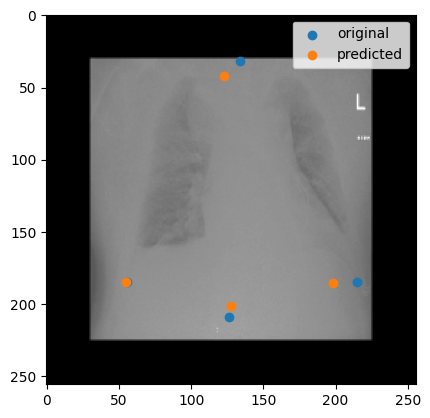

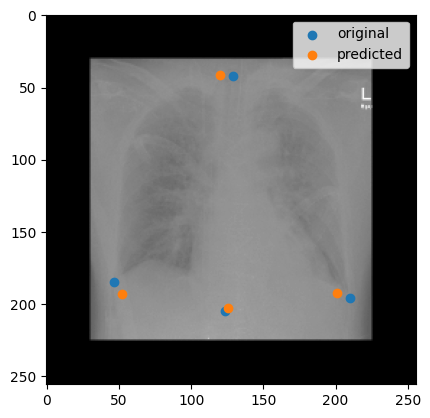

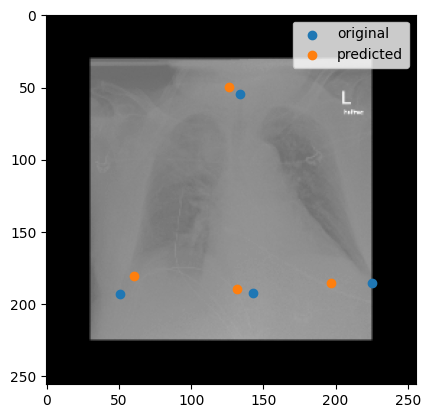

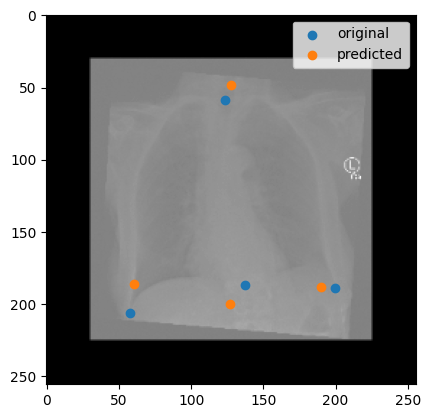

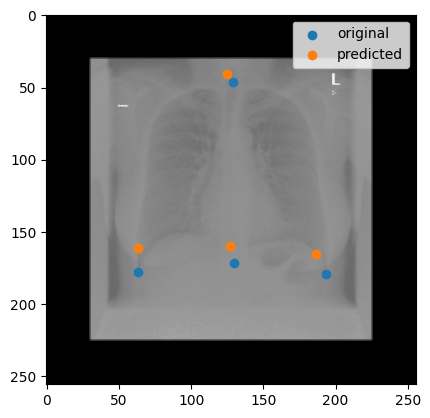

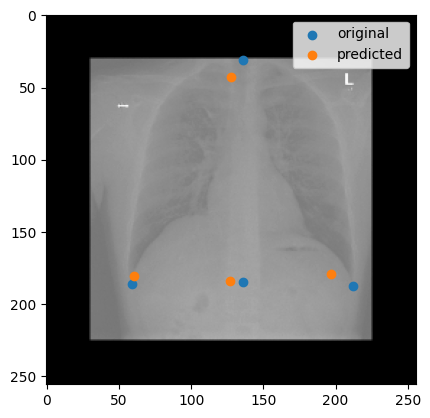

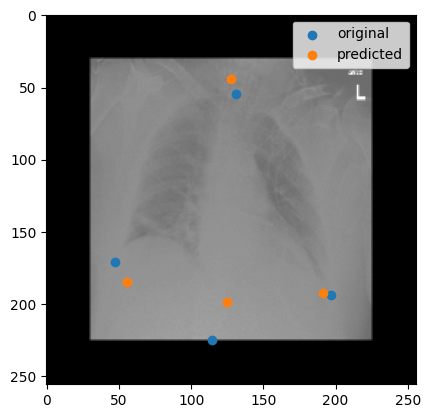

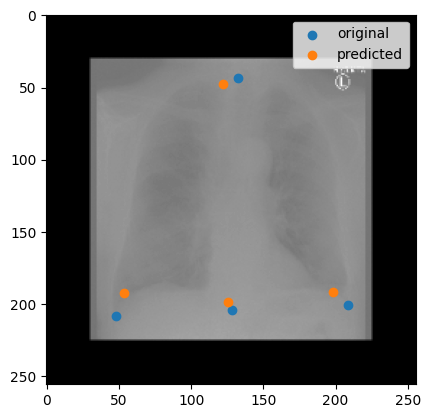

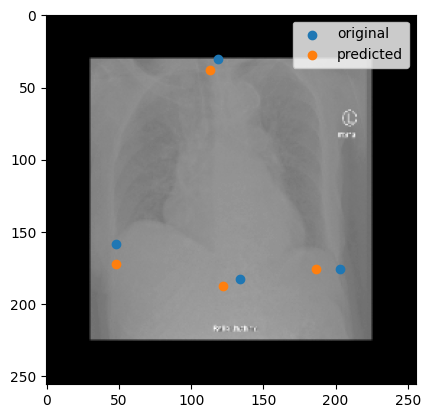

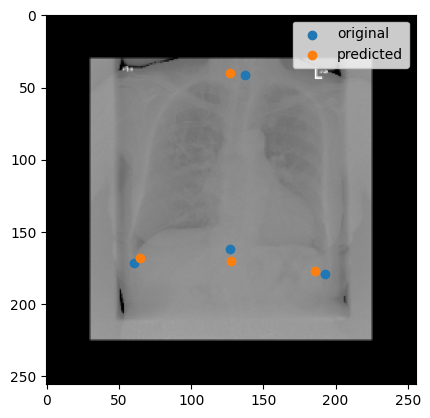

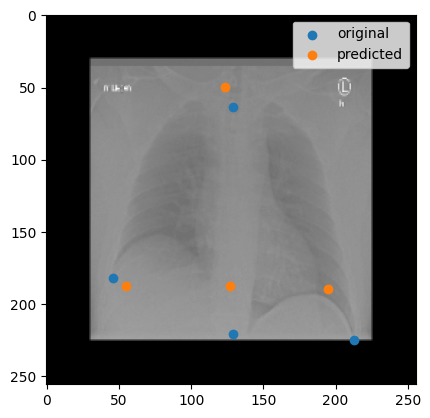

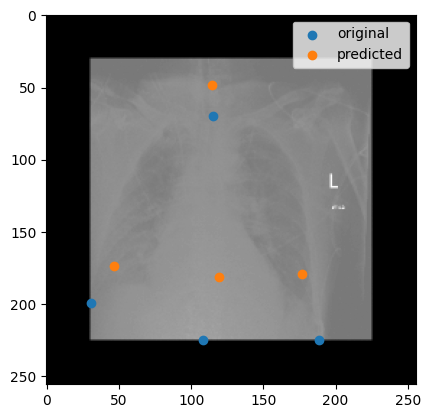

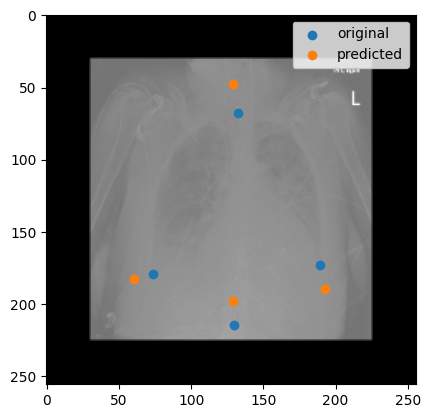

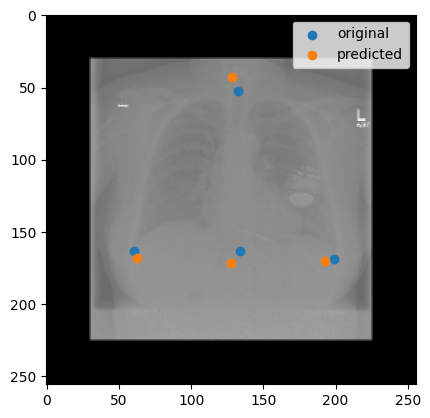

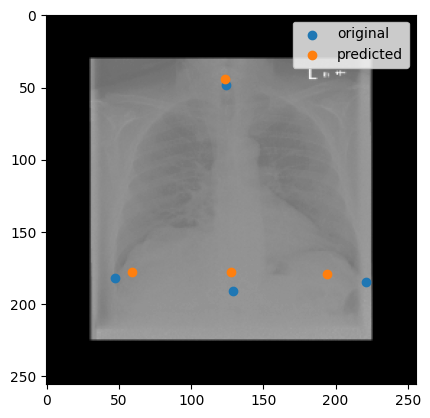

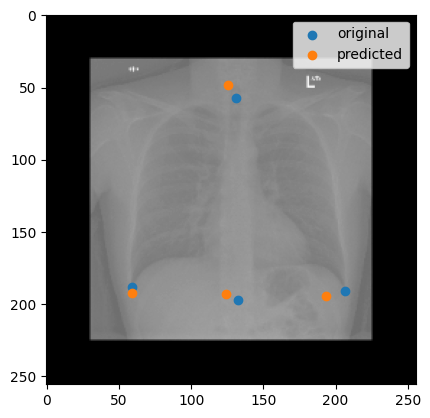

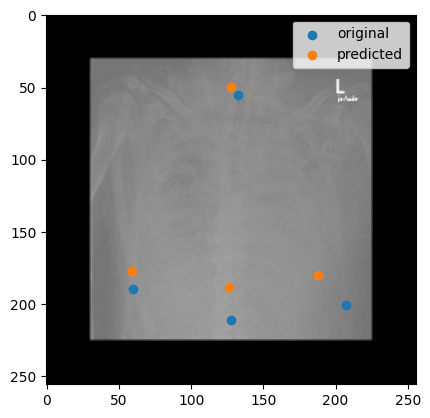

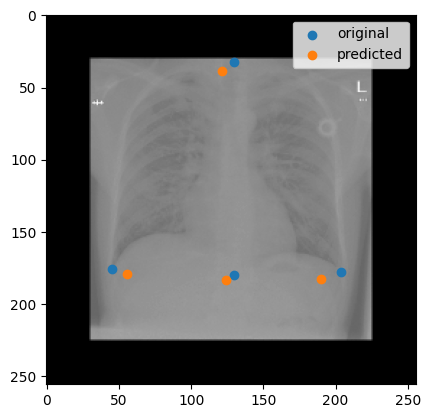

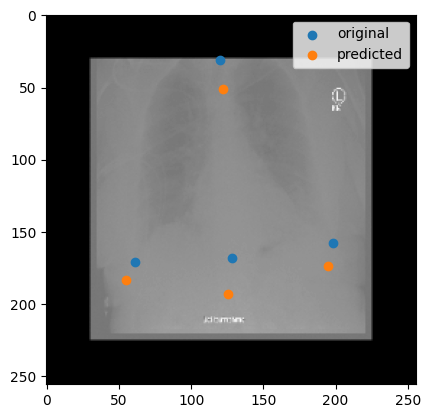

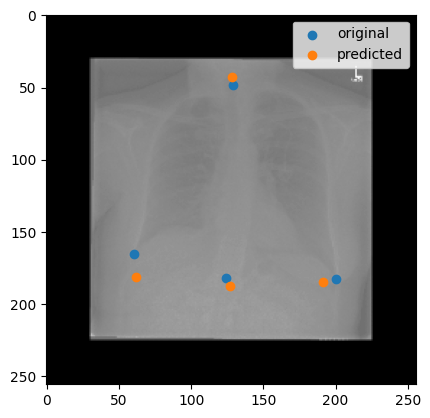

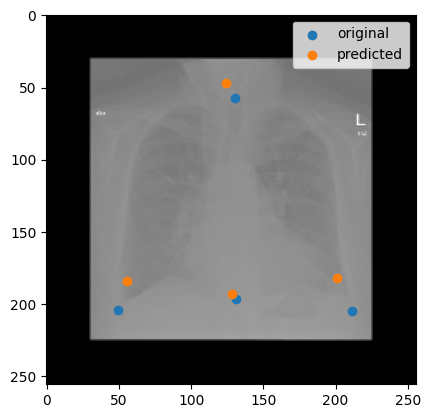

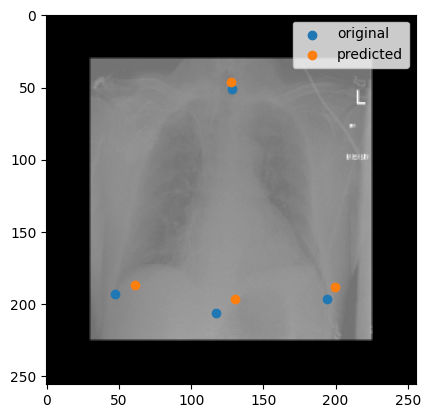

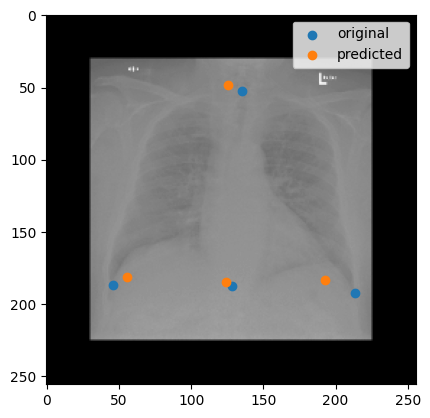

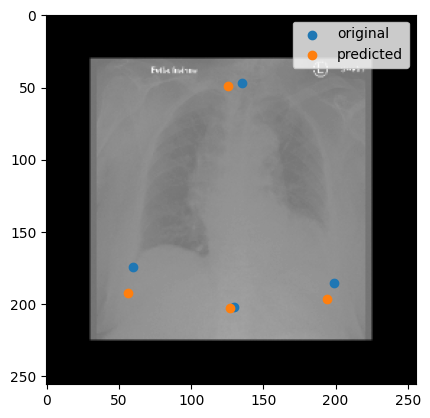

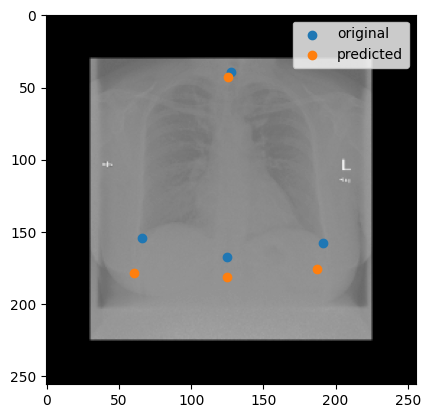

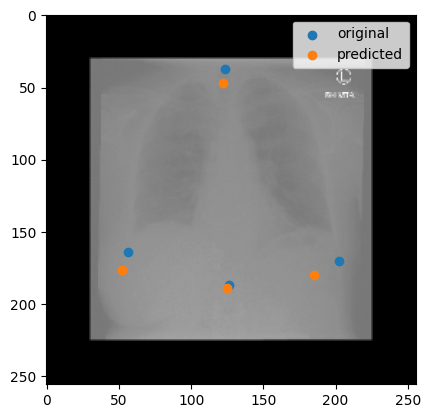

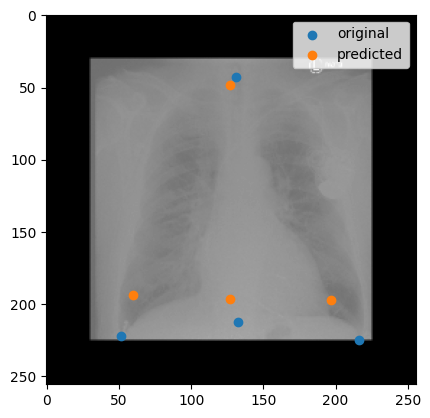

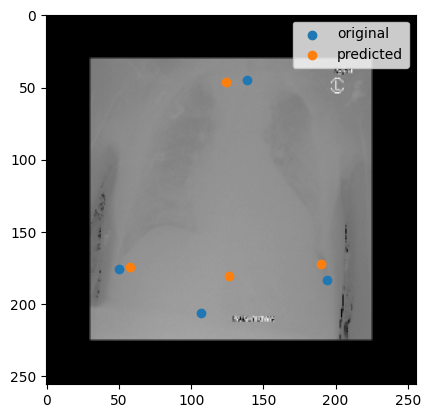

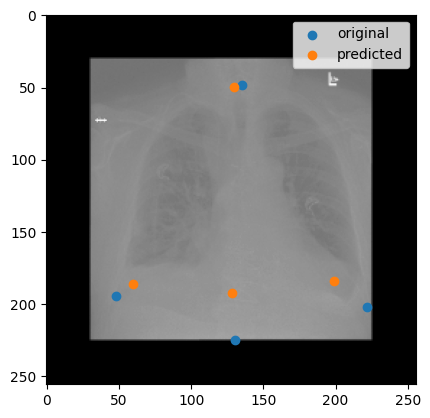

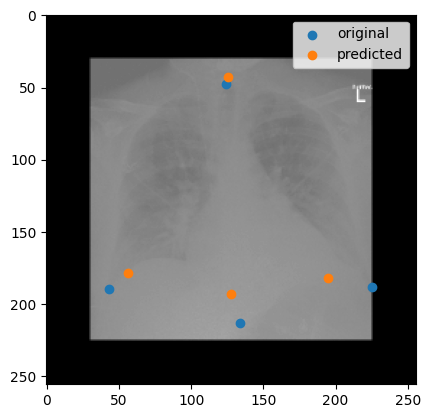

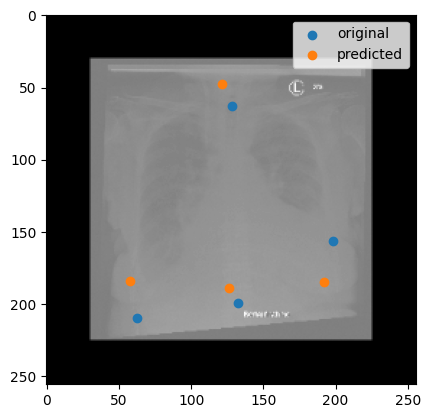

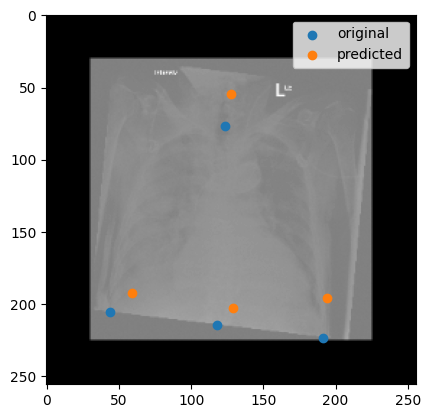

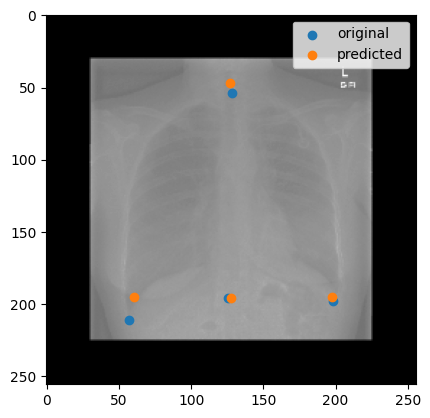

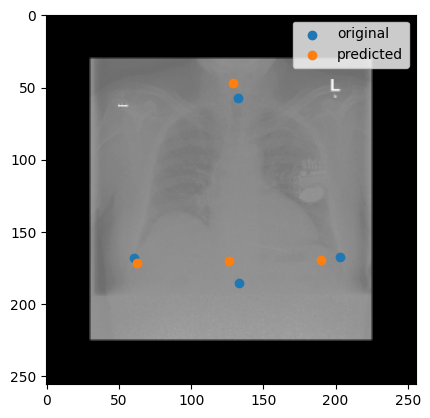

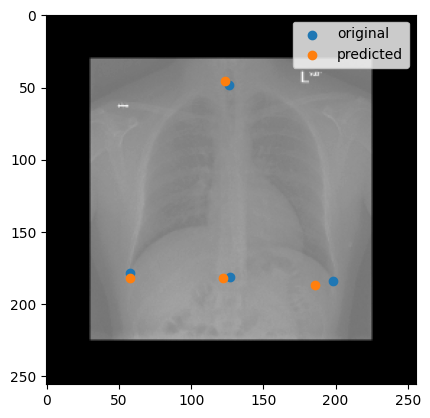

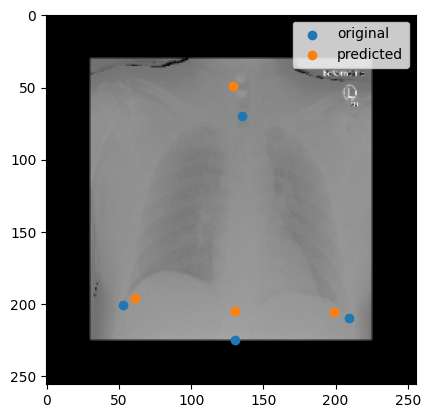

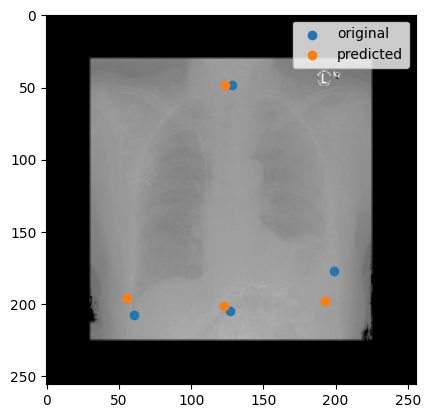

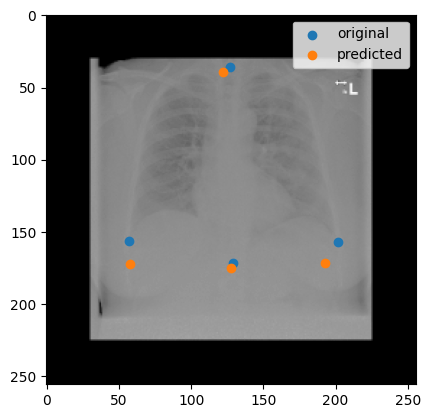

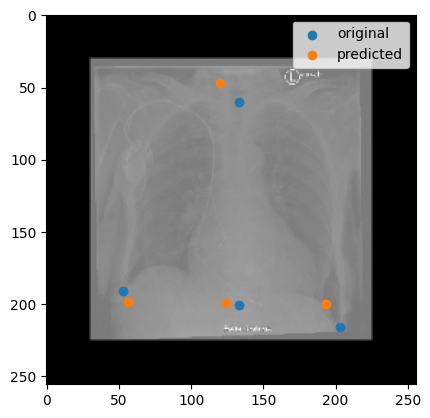

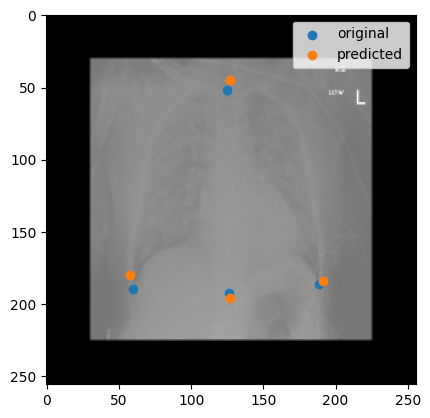

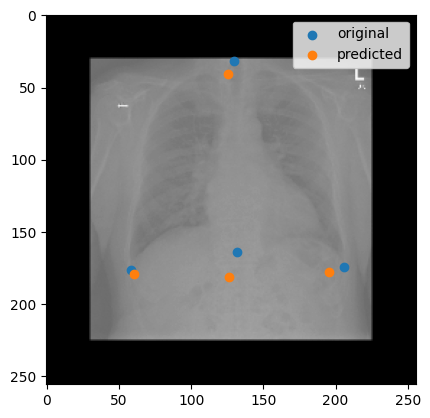

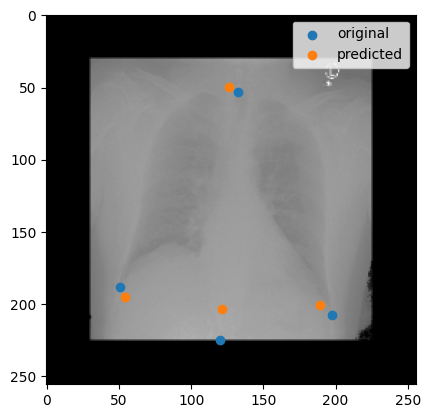

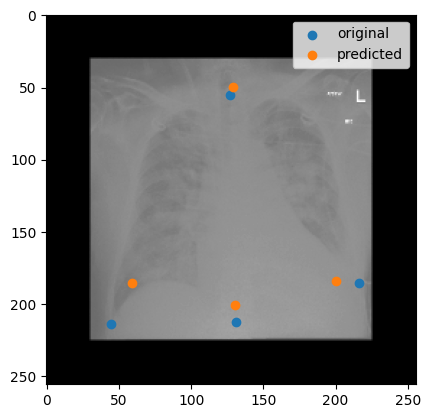

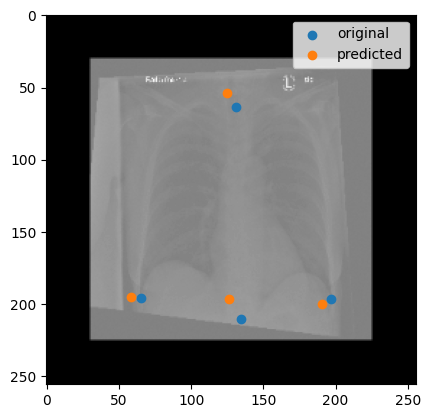

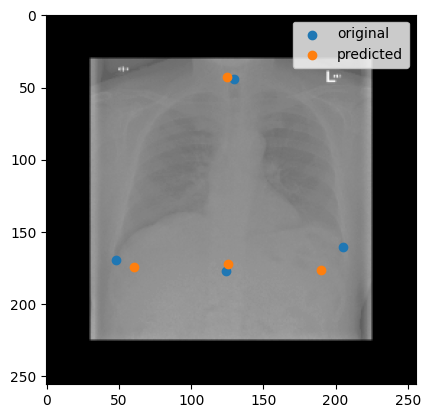

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 11.73 GiB of which 26.44 MiB is free. Process 2289190 has 3.06 GiB memory in use. Process 2293953 has 570.00 MiB memory in use. Process 2304572 has 1.51 GiB memory in use. Process 2307074 has 594.00 MiB memory in use. Including non-PyTorch memory, this process has 1.54 GiB memory in use. Process 2350132 has 4.04 GiB memory in use. Of the allocated memory 1.36 GiB is allocated by PyTorch, and 11.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
from Keypoint_dataset_poisson import get_loader_keypoint_simulated
train_loader, test_loader, validation_loader = get_loader_keypoint_simulated(BATCH_SIZE=1)

model = KeypointModel().to(device=DEVICE)
load_checkpoint(model, f'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection_poisson_1.pth.tar')

model.eval()
loss_func = nn.MSELoss()
loss = 0
for image, targ in test_loader:
        img = image.to(device = DEVICE)
        target = targ.to(DEVICE)
        pred = model(img)
        loss += loss_func(pred, target.squeeze(1))
        pred = pred[0].to('cpu').detach().numpy()
        plt.imshow(image[0][0], cmap='gray')
        for i in range(0, 8, 2):
                scatter2 = plt.scatter(targ[0,0,i], targ[0,0,i+1], color = 'C0')
                scatter1 = plt.scatter(pred[i], pred[i+1],color = 'C1')
        scatter1.set_label('predicted')
        scatter2.set_label('original')
        plt.legend()
        plt.show()

# compare error of lungs to spine

In [8]:
train_loader, test_loader = get_loader_keypoint(BATCH_SIZE = 8)
n = len(test_loader)
loss_fn = nn.MSELoss()
Keyp = KeypointModel().to(DEVICE)
checkpoint_Keyp = r'/home/alex/Documents/new try/Data/Studie_daten/safe_states/Keypoint_detection_padding_0.001_1_0_6.pth.tar'
load_checkpoint(Keyp, checkpoint_Keyp)
loss_lung = 0
loss_spine = 0
for image, targ in test_loader:
    img_Keyp = image.to(device = DEVICE)
    target = targ.to(DEVICE).squeeze(1)
    pred_keyp = Keyp(img_Keyp)
    loss_spine += loss_fn(pred_keyp[:,:4], target[:,:4]).item()
    loss_lung += loss_fn(pred_keyp[:,4:], target[:,4:]).item()

print(loss_spine/n)
print(loss_lung/n)

=> Loading checkpoint
64.07782454239695
127.99258964940121
